<a id="1"></a>
# Import data

In [1]:
# Spark Session, Pipeline, Functions, and Metrics
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

# Keras / Deep Learning
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.optimizers import Adam

# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator

from pyspark.sql.functions import col,isnan, when, count
from pyspark.sql.functions import col, create_map, lit
from itertools import chain

import numpy as np
import pandas as pd

WARNING


In [2]:
# from sklearn.preprocssing import MinMaxScalar

# scaler = MinMaxScaler()

# # x_train= scaler.fit_transform(X_train)
# # x_test = scaler.transform(X_test)

# # print(x_train.shape)
# # print(x_test.shape)
import sklearn.preprocessing as sk
import pandas as pd
x = np.array([[1,2,3,4,5,6,7,8,9,10],
             [10,20,30,100,20,1,3,2,5,1],
             [2,6,6,5,5,3,2,0,0,0]])

# df = pd.DataFrame(x, columns=['1'])


# scalar = sk.minmax_scale()
print(x)

[[  1   2   3   4   5   6   7   8   9  10]
 [ 10  20  30 100  20   1   3   2   5   1]
 [  2   6   6   5   5   3   2   0   0   0]]


In [3]:
df = pd.DataFrame({'features': x.tolist()})

In [4]:
df['features'][0]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [5]:
df = pd.DataFrame({'features': [1,2,3]})
scalar = sk.minmax_scale(df)

In [6]:
scalar

array([[0. ],
       [0.5],
       [1. ]])

In [7]:
# Spark Session
conf = SparkConf().setAppName('Predict Loan Payback').setMaster('local[6]') # 6 cores
sc = SparkContext(conf=conf)
sql_context = SQLContext(sc)

In [8]:
# sc.stop()
sc

<SparkContext master=local[6] appName=Predict Loan Payback>

In [9]:
# Load Data to Spark Dataframe
df = sql_context.read.csv("./data/accepted_2007_to_2018Q4.csv", header=True, inferSchema=True)

In [10]:
# View Schema
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

<a id="2"></a>
# Preprocessing

In [11]:
df.limit(5).toPandas()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,None,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,None,None,Cash,N,None,None,None,None,None,None
1,68355089,None,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,None,None,Cash,N,None,None,None,None,None,None
2,68341763,None,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,None,None,Cash,N,None,None,None,None,None,None
3,66310712,None,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,None,None,Cash,N,None,None,None,None,None,None
4,68476807,None,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,None,None,Cash,N,None,None,None,None,None,None


In [12]:
df.groupBy("loan_status").count().toPandas()

,loan_status,count
0,Fully Paid,1076751
1,Default,40
2,None,33
3,In Grace Period,8436
4,Does not meet the credit policy. Status:Fully ...,1988
5,Charged Off,268558
6,Oct-2015,1
7,Late (31-120 days),21467
8,Current,878317
9,Does not meet the credit policy. Status:Charge...,761


In [13]:
df = df.filter('loan_status in ("Fully Paid", "Charged Off")')

In [14]:
df.groupBy("loan_status").count().toPandas()

,loan_status,count
0,Fully Paid,1076751
1,Charged Off,268558


In [15]:
df = df.drop('id', 'pymnt_plan', 'hardship_flag', 'out_prncp', 'out_prncp_inv', 'policy_code')

In [16]:
def spark_df_shape(df):
    return df.count(), len(df.columns)

In [17]:
print(spark_df_shape(df))

(1345309, 145)


let's drop these columns, as it will not contribute to our goal.

In [18]:
to_drop = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

In [19]:
to_drop

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1345309,0,0,0,0,0,0,0,0,85785,...,1339554,1339554,226,171,1311942,1311957,1311977,1311998,1312012,1312016


In [20]:
to_drop.sum().sort_values(ascending=False).head(50)

member_id                                     1345309
next_pymnt_d                                  1345086
orig_projected_additional_accrued_interest    1341548
hardship_last_payment_amount                  1339554
hardship_payoff_balance_amount                1339554
hardship_dpd                                  1339550
hardship_loan_status                          1339548
hardship_start_date                           1339547
hardship_end_date                             1339546
hardship_length                               1339545
payment_plan_start_date                       1339543
hardship_amount                               1339540
deferral_term                                 1339532
hardship_status                               1339521
hardship_reason                               1339513
hardship_type                                 1339504
sec_app_mths_since_last_major_derog           1338662
sec_app_revol_util                            1327004
sec_app_num_rev_accts       

In [21]:
to_drop.sum().sort_values(ascending=False)[50:].head(50)

open_rv_12m                   807699
open_rv_24m                   807693
total_bal_il                  807685
open_il_24m                   807678
open_il_12m                   807673
open_act_il                   807645
open_acc_6m                   807631
mths_since_last_delinq        678599
mths_since_recent_inq         174049
num_tl_120dpd_2m              117400
mo_sin_old_il_acct            105485
emp_title                      85785
emp_length                     78511
pct_tl_nvr_dlq                 67681
avg_cur_bal                    67546
num_tl_30dpd                   67527
num_bc_tl                      67526
num_rev_accts                  67526
num_tl_op_past_12m             67525
num_actv_rev_tl                67525
num_tl_90g_dpd_24m             67525
num_rev_tl_bal_gt_0            67525
total_rev_hi_lim               67522
num_il_tl                      67521
num_op_rev_tl                  67520
num_actv_bc_tl                 67518
num_accts_ever_120_pd          67516
t

The first 95 columns has lots of nulls so I will drop them

In [22]:
to_drop = list(to_drop.sum().sort_values(ascending=False).head(95).index)

In [23]:
print(to_drop)

['member_id', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'hardship_last_payment_amount', 'hardship_payoff_balance_amount', 'hardship_dpd', 'hardship_loan_status', 'hardship_start_date', 'hardship_end_date', 'hardship_length', 'payment_plan_start_date', 'hardship_amount', 'deferral_term', 'hardship_status', 'hardship_reason', 'hardship_type', 'sec_app_mths_since_last_major_derog', 'sec_app_revol_util', 'sec_app_num_rev_accts', 'sec_app_open_act_il', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_open_acc', 'sec_app_mort_acc', 'sec_app_inq_last_6mths', 'sec_app_fico_range_low', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'verification_status_joint', 'dti_joint', 'annual_inc_joint', 'settlement_term', 'settlement_percentage', 'settlement_amount', 'settlement_date', 'settlement_status', 'debt_settlement_flag_date', 'desc', 'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_last_major_derog',

In [24]:
df = df.drop(*to_drop)

In [25]:
print((df.count(), len(df.columns)))

(1345309, 50)


In [26]:
df = df.na.drop()

In [27]:
print(spark_df_shape(df))

(1340812, 50)


In [28]:
to_drop = ['fico_range_low', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_pymnt', 'installment', 'collection_recovery_fee', 'total_rec_prncp', 'last_fico_range_low']
df = df.drop(*to_drop)

In [29]:
print(spark_df_shape(df))

(1340812, 41)


In [30]:
mapping = {'Fully Paid': 1, 'Charged Off': 0}

mapping_expr = create_map([lit(x) for x in chain(*mapping.items())])

df = df.withColumn("loan_is_paid", mapping_expr[col("loan_status")])

In [31]:
df.groupBy("loan_is_paid").count().toPandas()

,loan_is_paid,count
0,1,1074961
1,0,265851


In [32]:
df = df.drop('loan_status')

In [33]:
distinct_terms = [x.term for x in df.select('term').distinct().collect()]

In [34]:
distinct_terms

[' 36 months', ' 60 months']

In [35]:
mapping = dict(zip(distinct_terms, [36, 60]))
mapping_expr = create_map([lit(x) for x in chain(*mapping.items())])
df = df.withColumn("term_months", mapping_expr[col("term")])

In [36]:
df.select("term_months").distinct().show()

+-----------+
|term_months|
+-----------+
|         60|
|         36|
+-----------+



In [37]:
df = df.drop('term')

In [38]:
df.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- url: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- fico_range_high: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- total_rec_int: string (n

In [39]:
df.groupBy('home_ownership').count().toPandas()

,home_ownership,count
0,OWN,144179
1,RENT,532381
2,MORTGAGE,663782
3,ANY,283
4,OTHER,142
5,NONE,45


In [40]:
df = df.replace('NONE', 'ANY', 'home_ownership')

In [41]:
df.groupBy('home_ownership').count().toPandas()

,home_ownership,count
0,OWN,144179
1,RENT,532381
2,MORTGAGE,663782
3,ANY,328
4,OTHER,142


In [42]:
to_drop=['grade', 'issue_d', 'url', 'last_pymnt_d', 'last_credit_pull_d', 'zip_code', 'addr_state', 'earliest_cr_line']
df = df.drop(*to_drop)

In [43]:
df.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- fico_range_high: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- total_rec_int: string (nullable = true)
 |-- total_rec_late_fee: string (nullable = true)
 |-- recoveries: string (nullable = true)
 |-- last_pymnt_amnt: string (nullable = true)
 |-- last_fico_range_high: string (nullable = true)
 |-- collections_12_mths_ex_med: s

In [44]:
cols = ['annual_inc', 'dti', 'delinq_2yrs', 'fico_range_high', 'inq_last_6mths', 
        'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_int', 
        'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt', 'last_fico_range_high', 
        'collections_12_mths_ex_med', 'acc_now_delinq']
for col_name in cols:
    df = df.withColumn(col_name, col(col_name).cast('float'))

In [45]:
df.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: float (nullable = true)
 |-- fico_range_high: float (nullable = true)
 |-- inq_last_6mths: float (nullable = true)
 |-- open_acc: float (nullable = true)
 |-- pub_rec: float (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- total_acc: float (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- total_rec_int: float (nullable = true)
 |-- total_rec_late_fee: float (nullable = true)
 |-- recoveries: float (nullable = true)
 |-- last_pymnt_amnt: float (nullable = true)
 |-- last_fico_range_high: float (nullable = true)
 |-- collections_12_mths_ex_med: float (nullable 

In [46]:
df.limit(5).toPandas()

,loan_amnt,int_rate,sub_grade,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_high,...,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,disbursement_method,debt_settlement_flag,loan_is_paid,term_months
0,3600.0,13.99,C4,MORTGAGE,55000.0,Not Verified,debt_consolidation,5.910000,0.0,679.0,...,Individual,0.0,0.0,0.0,0.0,0.0,Cash,N,1,36
1,24700.0,11.99,C1,MORTGAGE,65000.0,Not Verified,small_business,16.059999,1.0,719.0,...,Individual,0.0,0.0,0.0,0.0,0.0,Cash,N,1,36
2,20000.0,10.78,B4,MORTGAGE,63000.0,Not Verified,home_improvement,10.780000,0.0,699.0,...,Joint App,0.0,0.0,0.0,0.0,0.0,Cash,N,1,60
3,10400.0,22.45,F1,MORTGAGE,104433.0,Source Verified,major_purchase,25.370001,1.0,699.0,...,Individual,0.0,0.0,0.0,0.0,0.0,Cash,N,1,60
4,11950.0,13.44,C3,RENT,34000.0,Source Verified,debt_consolidation,10.200000,0.0,694.0,...,Individual,0.0,0.0,0.0,0.0,0.0,Cash,N,1,36


In [47]:
# Spark Pipeline
cat_features = ['sub_grade', 'verification_status', 'application_type', 'initial_list_status', 
                'purpose', 'home_ownership', 'disbursement_method', 'debt_settlement_flag']
assembler_inputs = list(set(df.columns) - set(cat_features)) + [feature + "_class_vec" for feature in cat_features]
assembler_inputs.remove('loan_is_paid')
assembler_inputs

['tax_liens',
 'dti',
 'fico_range_high',
 'pub_rec',
 'total_rec_int',
 'loan_amnt',
 'total_acc',
 'collections_12_mths_ex_med',
 'last_pymnt_amnt',
 'acc_now_delinq',
 'recoveries',
 'term_months',
 'delinq_amnt',
 'chargeoff_within_12_mths',
 'open_acc',
 'pub_rec_bankruptcies',
 'last_fico_range_high',
 'delinq_2yrs',
 'total_rec_late_fee',
 'int_rate',
 'revol_util',
 'inq_last_6mths',
 'revol_bal',
 'annual_inc',
 'sub_grade_class_vec',
 'verification_status_class_vec',
 'application_type_class_vec',
 'initial_list_status_class_vec',
 'purpose_class_vec',
 'home_ownership_class_vec',
 'disbursement_method_class_vec',
 'debt_settlement_flag_class_vec']

In [48]:
# Pipeline Stages List
stages = []

# Loop for StringIndexer and OHE for Categorical Variables
for features in cat_features:
    # Index Categorical Features
    string_indexer = StringIndexer(inputCol=features, outputCol=features + "_index")
    # One Hot Encode Categorical Features
    encoder = OneHotEncoder(inputCols=[string_indexer.getOutputCol()], outputCols=[features + "_class_vec"])
    # Append Pipeline Stages
    stages += [string_indexer, encoder]
    
assembler_final = VectorAssembler(inputCols=assembler_inputs, outputCol="features") 

scalar = MinMaxScaler(inputCol='features', outputCol='scaled_features')

stages += [assembler_final, scalar]

In [49]:
stages

[StringIndexer_75866dd8040f,
 OneHotEncoder_e5610f249866,
 StringIndexer_dc0bbb79cd1d,
 OneHotEncoder_86c8d7239e83,
 StringIndexer_9179443c1993,
 OneHotEncoder_d7bf4e8777b6,
 StringIndexer_9e67d2a01b6b,
 OneHotEncoder_0d3864efd853,
 StringIndexer_ff38be680a86,
 OneHotEncoder_9a8bcd985ee0,
 StringIndexer_9a18d6e28072,
 OneHotEncoder_3f76e5f2dddd,
 StringIndexer_8c35f3fb3bbb,
 OneHotEncoder_f35cc6eccc9f,
 StringIndexer_7b8983afb5ba,
 OneHotEncoder_1ad18e044733,
 VectorAssembler_262c906d8fd2,
 MinMaxScaler_97f94fe9bb18]

In [50]:
# Set Pipeline
pipeline = Pipeline(stages=stages)

In [51]:
# Fit Pipeline to Data
pipeline_model = pipeline.fit(df)

In [52]:
# Transform Data using Fitted Pipeline
trans_df = pipeline_model.transform(df)

In [53]:
# Preview Newly Transformed Data
trans_df.limit(5).toPandas()

,loan_amnt,int_rate,sub_grade,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,fico_range_high,...,purpose_index,purpose_class_vec,home_ownership_index,home_ownership_class_vec,disbursement_method_index,disbursement_method_class_vec,debt_settlement_flag_index,debt_settlement_flag_class_vec,features,scaled_features
0,3600.0,13.99,C4,MORTGAGE,55000.0,Not Verified,debt_consolidation,5.910000,0.0,679.0,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,(1.0),"(0.0, 5.909999847412109, 679.0, 0.0, 821.71997...","(0.0, 0.006909999847412109, 0.0806451612903225..."
1,24700.0,11.99,C1,MORTGAGE,65000.0,Not Verified,small_business,16.059999,1.0,719.0,...,6.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,(1.0),"(0.0, 16.059999465942383, 719.0, 0.0, 979.6599...","(0.0, 0.017059999465942385, 0.2956989247311828..."
2,20000.0,10.78,B4,MORTGAGE,63000.0,Not Verified,home_improvement,10.780000,0.0,699.0,...,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,(1.0),"(0.0, 10.779999732971191, 699.0, 0.0, 2705.919...","(0.0, 0.011779999732971192, 0.1881720430107527..."
3,10400.0,22.45,F1,MORTGAGE,104433.0,Source Verified,major_purchase,25.370001,1.0,699.0,...,4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0)",0.0,(1.0),0.0,(1.0),"(0.0, 25.3700008392334, 699.0, 0.0, 1340.5, 10...","(0.0, 0.0263700008392334, 0.18817204301075272,..."
4,11950.0,13.44,C3,RENT,34000.0,Source Verified,debt_consolidation,10.200000,0.0,694.0,...,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0,"(0.0, 1.0, 0.0, 0.0)",0.0,(1.0),0.0,(1.0),"(0.0, 10.199999809265137, 694.0, 0.0, 1758.949...","(0.0, 0.011199999809265136, 0.1612903225806451..."


In [54]:
trans_df.printSchema()

root
 |-- loan_amnt: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: float (nullable = true)
 |-- fico_range_high: float (nullable = true)
 |-- inq_last_6mths: float (nullable = true)
 |-- open_acc: float (nullable = true)
 |-- pub_rec: float (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- total_acc: float (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- total_rec_int: float (nullable = true)
 |-- total_rec_late_fee: float (nullable = true)
 |-- recoveries: float (nullable = true)
 |-- last_pymnt_amnt: float (nullable = true)
 |-- last_fico_range_high: float (nullable = true)
 |-- collections_12_mths_ex_med: float (nullable 

In [55]:
# cols = list(set(df.columns) - {'features'})
dl_df = trans_df.select('scaled_features', 'loan_is_paid')

In [56]:
dl_df.printSchema()

root
 |-- scaled_features: vector (nullable = true)
 |-- loan_is_paid: integer (nullable = true)



In [57]:
dl_df.show(1)

+--------------------+------------+
|     scaled_features|loan_is_paid|
+--------------------+------------+
|(81,[1,2,4,5,6,8,...|           1|
+--------------------+------------+
only showing top 1 row



In [58]:
# Number of Inputs or Input Dimensions
input_dim = 81

In [67]:
def create_model():
    # Set up Deep Learning Model / Architecture
    model = Sequential()
    model.add(Dense(units=78, input_shape=(input_dim,), activation='relu'))
    model.add(Dense(units=39,activation='relu'))
    model.add(Dense(units=19,activation='relu'))
    model.add(Dense(units=8,activation='relu'))
    model.add(Dense(units=4,activation='relu'))
    model.add(Dense(units=1,activation='sigmoid'))
    return model

def compile_model(model):
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [68]:
model = create_model()
model = compile_model(model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 78)                6396      
_________________________________________________________________
dense_7 (Dense)              (None, 39)                3081      
_________________________________________________________________
dense_8 (Dense)              (None, 19)                760       
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 160       
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 10,438
Trainable params: 10,438
Non-trainable params: 0
__________________________________________________

In [61]:
dl_df = dl_df.toPandas()

In [62]:
series = dl_df['scaled_features'].apply(lambda x : np.array(x.toArray())).to_numpy().reshape(-1,1)

In [63]:
dl_x = np.apply_along_axis(lambda x : x[0], 1, series)

In [64]:
dl_y = dl_df.loan_is_paid.values

In [65]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dl_x, dl_y, test_size=0.2, random_state=42)

In [69]:
model.fit(x=x_train, y=y_train, epochs=40, batch_size=512, validation_data=(x_test, y_test), verbose=1)

Epoch 1/40
2096/2096 [==============================] - 33s 10ms/step - loss: 0.5434 - accuracy: 0.8413 - val_loss: 0.1932 - val_accuracy: 0.9663
Epoch 2/40
2096/2096 [==============================] - 23s 11ms/step - loss: 0.1654 - accuracy: 0.9668 - val_loss: 0.1250 - val_accuracy: 0.9628
Epoch 3/40
2096/2096 [==============================] - 25s 12ms/step - loss: 0.1009 - accuracy: 0.9713 - val_loss: 0.0843 - val_accuracy: 0.9722
Epoch 4/40
2096/2096 [==============================] - 27s 13ms/step - loss: 0.0783 - accuracy: 0.9740 - val_loss: 0.0769 - val_accuracy: 0.9717
Epoch 5/40
2096/2096 [==============================] - 28s 13ms/step - loss: 0.0690 - accuracy: 0.9757 - val_loss: 0.0650 - val_accuracy: 0.9766
Epoch 6/40
2096/2096 [==============================] - 29s 14ms/step - loss: 0.0650 - accuracy: 0.9765 - val_loss: 0.0688 - val_accuracy: 0.9737
Epoch 7/40
2096/2096 [==============================] - 31s 15ms/step - loss: 0.0623 - accuracy: 0.9772 - val_loss: 0.0607 -

In [70]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

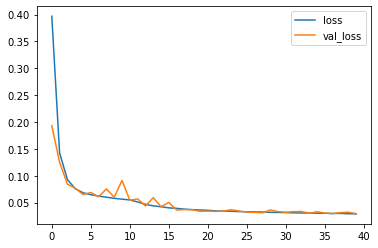

In [71]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

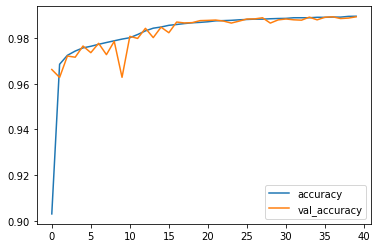

In [72]:
losses[['accuracy','val_accuracy']].plot()

In [73]:
model.save('loan_prediction_model')

INFO:tensorflow:Assets written to: loan_prediction_model/assets


In [76]:
spark_df = trans_df.select('scaled_features', 'loan_is_paid')

In [77]:
spark_train, spark_test = spark_df.randomSplit([.8, .2], seed=42)

In [78]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(labelCol = 'loan_is_paid', featuresCol = 'scaled_features')

In [79]:
gbModel = gb.fit(spark_train)

In [80]:
gb_predictions = gbModel.transform(spark_test)

In [81]:
gbModel.save('gbtc_loan_prediction')

In [83]:
gb_predictions.select('scaled_features', 'loan_is_paid', 'prediction', 'probability').show(10)

+--------------------+------------+----------+--------------------+
|     scaled_features|loan_is_paid|prediction|         probability|
+--------------------+------------+----------+--------------------+
|(81,[0,1,2,3,4,5,...|           1|       1.0|[0.05270399993585...|
|(81,[0,1,2,3,4,5,...|           1|       1.0|[0.05443185145658...|
|(81,[0,1,2,3,4,5,...|           0|       0.0|[0.95635347857271...|
|(81,[0,1,2,3,4,5,...|           0|       0.0|[0.95635347857271...|
|(81,[0,1,2,3,4,5,...|           0|       0.0|[0.95635347857271...|
|(81,[0,1,2,3,4,5,...|           0|       0.0|[0.95635347857271...|
|(81,[0,1,2,3,4,5,...|           0|       0.0|[0.95635347857271...|
|(81,[0,1,2,3,4,5,...|           1|       1.0|[0.04368680010337...|
|(81,[0,1,2,3,4,5,...|           1|       1.0|[0.08128007245037...|
|(81,[0,1,2,3,4,5,...|           0|       1.0|[0.27032648846438...|
+--------------------+------------+----------+--------------------+
only showing top 10 rows



In [98]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol='loan_is_paid', metricName='areaUnderROC')

print("Test Area Under ROC: " + str(evaluator.evaluate(gb_predictions)))

Test Area Under ROC: 0.9524807005159022


In [99]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='loan_is_paid', metricName='f1')
print('Test f1 score: ', evaluator.evaluate(gb_predictions))

Test f1 score:  0.9744686686161473


In [100]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='loan_is_paid', metricName='accuracy')
print('Test accuracy: ', evaluator.evaluate(gb_predictions))

Test accuracy:  0.9746691093995363


In [101]:
gb_predictions.select('loan_is_paid','prediction').groupBy('loan_is_paid','prediction').count().show()

+------------+----------+------+
|loan_is_paid|prediction| count|
+------------+----------+------+
|           1|       0.0|  2304|
|           0|       0.0| 48570|
|           1|       1.0|212115|
|           0|       1.0|  4471|
+------------+----------+------+

